# Accuracy Comparison

In [218]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import statistics

# Local packages
from simulate import *

In [219]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
with open('polybench-subset-mf.pkl', 'rb') as file:
    mf = pickle.load(file)
with open('polybench-subset-normal.pkl', 'rb') as file:
    norm = pickle.load(file)

In [220]:
#nomf = ['atax', 'bicg', 'ftdt-2d', 'lu']

In [104]:
names = list(mf.st.keys())
y_norm_mean = [norm.st[n].IPC.mean for n in names]
y_norm_sem  = [norm.st[n].IPC.sem  for n in names]
y_mf_mean   = [mf.st[n].IPC.mean   for n in names]
y_mf_sem    = [mf.st[n].IPC.sem    for n in names]

def calc_mean(xs):
    xs = (sorted(xs))[1:-1]
    return np.mean(xs)

def calc_sd(xs):
    xs = (sorted(xs))[1:-1]
    return statistics.stdev(xs)

# WARNING - CHANGING SEM TO SD
y_norm_mean = [calc_mean(norm.st[n].ipc) for n in names]
y_norm_sem   = [calc_sd(norm.st[n].ipc) for n in names]
y_mf_mean   = [calc_mean(mf.st[n].ipc) for n in names]
y_mf_sem     = [calc_sd(mf.st[n].ipc) for n in names]

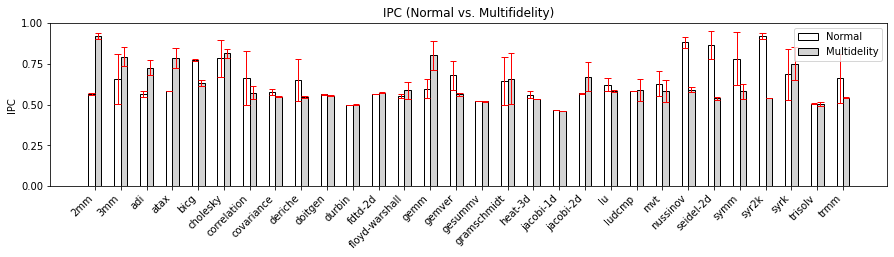

In [217]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-(width/2), y_norm_mean, width, color='white', label='Normal', edgecolor='black')
ax.bar(x+(width/2), y_mf_mean, width, color='lightgrey', label='Multidelity', edgecolor='black')

lines = []
for i in range(len(names)):
    #horizontal lines
    #lines.append([(i-(width/2),y_norm_mean[i]-y_norm_sem[i]), (i-(width/2),y_norm_mean[i]+y_norm_sem[i])])
    lines.append([(i-width,y_norm_mean[i]-y_norm_sem[i]), (i,y_norm_mean[i]-y_norm_sem[i])])
    lines.append([(i-width,y_norm_mean[i]+y_norm_sem[i]), (i,y_norm_mean[i]+y_norm_sem[i])])
    lines.append([(i,y_mf_mean[i]-y_mf_sem[i]), (i+width,y_mf_mean[i]-y_mf_sem[i])])
    lines.append([(i,y_mf_mean[i]+y_mf_sem[i]), (i+width,y_mf_mean[i]+y_mf_sem[i])])
    
    # vertical lines
    lines.append([(i-width/2,y_norm_mean[i]-y_norm_sem[i]),(i-width/2,y_norm_mean[i]+y_norm_sem[i])])
    lines.append([(i+width/2,y_mf_mean[i]-y_mf_sem[i]),(i+width/2,y_mf_mean[i]+y_mf_sem[i])])


#c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

lc = mc.LineCollection(lines, linewidths=1, color='red')
ax.add_collection(lc)

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,1))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 5
ax.set_yticks([(1/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
#plt.tight_layout()

In [170]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_mean[i], y_norm_mean[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  2mm             62.88%
1  3mm             20.75%
2  adi             28.18%
3  atax            35.14%
4  bicg           -18.07%
5  cholesky        03.74%
6  correlation    -13.43%
7  covariance     -05.00%
8  deriche        -15.94%
9  doitgen        -01.44%
10 durbin          00.89%
11 fdtd-2d         01.11%
12 floyd-warshall  06.18%
13 gemm            34.33%
14 gemver         -17.15%
15 gesummv        -00.38%
16 gramschmidt     02.29%
17 heat-3d        -04.85%
18 jacobi-1d      -00.85%
19 jacobi-2d       18.00%
20 lu             -06.32%
21 ludcmp          01.17%
22 mvt            -07.43%
23 nussinov       -32.98%
24 seidel-2d      -37.77%
25 symm           -25.58%
26 syr2k          -41.34%
27 syrk            09.24%
28 trisolv        -00.03%
29 trmm           -17.80%

MAPE: 15.67%


In [204]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup_pct = [((norm_times_seconds[i] / mf_times_seconds[i])-1)*100 for i in range(len(names))]

print('Percent speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup_pct[i]: 7.2f}%')

print(f'\nAverage percent speedup: {np.mean(speedup_pct):.2f}%')

Percent speedup

0  2mm             -42.66%
1  3mm             -32.03%
2  adi             -46.17%
3  atax            -58.29%
4  bicg            -59.28%
5  cholesky        -33.92%
6  correlation      -7.46%
7  covariance      -11.45%
8  deriche         -25.74%
9  doitgen         -27.55%
10 durbin          -29.13%
11 fdtd-2d         -61.18%
12 floyd-warshall  -31.78%
13 gemm            -45.38%
14 gemver          -52.94%
15 gesummv         -44.29%
16 gramschmidt     -20.67%
17 heat-3d         -36.60%
18 jacobi-1d       -35.17%
19 jacobi-2d       -38.18%
20 lu              -59.18%
21 ludcmp          -31.36%
22 mvt             -41.29%
23 nussinov          6.18%
24 seidel-2d        -7.15%
25 symm             -6.40%
26 syr2k            17.16%
27 syrk            -32.31%
28 trisolv         -46.37%
29 trmm             -5.84%

Average percent speedup: -31.55%


In [209]:
[i*nu.s for i in mf_times_seconds]

[289.6456414883145,
 231.95524850027135,
 188.4410513941696,
 41.430275179642805,
 38.51354306052458,
 204.90598524214383,
 152.20540947218726,
 148.84382558457636,
 176.33143851470217,
 161.68004774729428,
 9.424788868649877,
 254.06616947089316,
 181.31475363629428,
 237.4050890453375,
 59.065044555236625,
 13.821831622995845,
 177.37123211243352,
 115.87223610278878,
 5.498606268774229,
 205.2673934389582,
 280.04421233156637,
 156.22262142298464,
 30.763044039185743,
 191.30143201033624,
 121.73766898212271,
 152.30023171273078,
 135.26040416637562,
 186.687110864802,
 10.766388111996843,
 148.6547229448639]

In [192]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [186]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

470.7566602

In [193]:
mf_times_seconds_noariel

[-403.9417309765455,
 -319.9627941946764,
 -235.36095815722638,
 -28.709049353268725,
 -23.995811608040437,
 -259.3748955947245,
 -187.39011966190003,
 -181.9637889126902,
 -214.9827034084047,
 -202.6080353549823,
 -11.05003806340347,
 -158.51878560231728,
 -245.27482214923037,
 -331.52178250021353,
 -43.504893261163936,
 -12.236530646484946,
 -225.27030711442234,
 -137.66307894328898,
 -5.612472317179396,
 -277.62595960989586,
 -158.19667657319326,
 -195.48089572318972,
 -30.778349411022884,
 -242.9766251645569,
 -144.3556727658222,
 -192.53340344009337,
 -157.5840394342343,
 -266.98424196515805,
 -9.486101192585199,
 -186.83313876532168]

In [196]:
norm.st['deriche']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999            254.418   
1            memHierarchy.Bus   24576113             13.962   
2          memHierarchy.Cache  155077942            331.588   
3  memHierarchy.MemController   49999999            102.050   
4         memHierarchy.Parrot   78646625             68.045   

    avg. handler time (ns)  
0                     1272  
1                      568  
2                     2138  
3                     2041  
4                      865  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      4725089           0.436                    92
1  memHierarchy.MemLink    105901573         250.344                  2363
2   memHierarchy.Parrot    100380124          42.935                   427
Simulated time:
  2.37 (+/-0.16) ms
Wallclock Time:
  Real: 30206.85 (+/-476.47) ms
  User: 29819.93 (+/-

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]